In [5]:
import torch
import torch.nn.functional as F
import math
import numpy as np
import argparse
from torchvision import datasets, transforms
import random
import copy
import torch.nn as nn
import sys
from torch.utils.data import random_split

In [6]:
train_size = 5000
test_size = 5000
d = 784
device = torch.device('cpu')

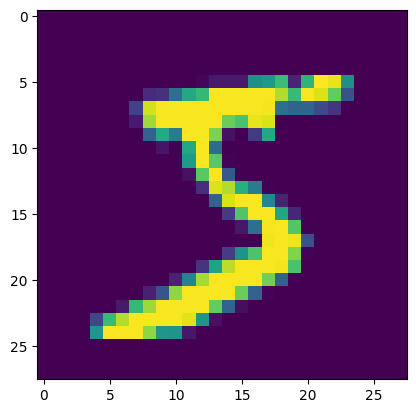

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = datasets.MNIST('MNIST', train=True, download=True,
                          transform=transform)
testset = datasets.MNIST('MNIST', train=False,
                         transform=transform)

import matplotlib.pyplot as plt

plt.imshow(trainset.data[0])

trainset = \
random_split(trainset, [train_size, trainset.data.shape[0] - train_size], generator=torch.Generator().manual_seed(7))[0]
testset = \
random_split(testset, [test_size, testset.data.shape[0] - test_size], generator=torch.Generator().manual_seed(7))[0]

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=test_size, shuffle=False)

In [8]:
def euclidean_distances(samples, centers, squared=True):
    '''Calculate the pointwise distance.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        squared: boolean.

    Returns:
        pointwise distances (n_sample, n_center).
    '''
    samples_norm = torch.sum(samples ** 2, dim=1, keepdim=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = torch.sum(centers ** 2, dim=1, keepdim=True)
    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)
    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def gaussian(samples, centers, bandwidth):
    '''Gaussian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.clamp_(min=0)
    gamma = 1. / (2 * bandwidth ** 2)
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat


def laplacian(samples, centers, bandwidth):
    '''Laplacian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat.clamp_(min=0)
    gamma = 1. / bandwidth
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat

In [9]:
def corrupting_label(label,noise_level):
    n = len(label)
    s = int(n*noise_level)
    mask = np.array([0]*(n-s) + [1]*s)
    np.random.shuffle(mask)
    for i in range(n):
        noise_label = np.random.randint(10)
        if mask[i] == 1:
            while(noise_label == label[i]):
                noise_label = np.random.randint(10)
            label[i] = noise_label
    return label

In [10]:
train_errs= []
test_errs = []
noises = np.linspace(0,1,1)

In [12]:
for noise in noises:
    for (data,target) in train_loader:
        data, target = data.to(device).reshape(-1,d).double()/math.sqrt(d), target.to(device)
        target = corrupting_label(target,noise)
        one_hot = nn.functional.one_hot(target,10).double()
        kernel_train = laplacian(data,data,1.0)
        print(f'kernel_train shape is {kernel_train.shape}')
        a = torch.inverse(kernel_train)@one_hot
        print(f'shape of a is {a.shape}')
        output = kernel_train@a
        train_loss = torch.norm(output - one_hot)**2/train_size
        pred = output.argmax(dim=1,keepdim = True)
        correct = pred.eq(target.view_as(pred)).sum()
        accuracy = correct/train_size
        print(f'training loss is :{train_loss}, training accuracy :{accuracy}')
    for (data_test,target_test) in test_loader:
        data_test, target_test = data_test.to(device).reshape(-1,d).double()/math.sqrt(d), target_test.to(device)
        target_test = corrupting_label(target_test,noise)
        one_hot_test = nn.functional.one_hot(target_test,10).double()
        kernel_test = laplacian(data_test,data,1.0)
        output_test = kernel_test@a
        test_loss = torch.norm(output_test - one_hot_test)**2/test_size
        pred = output_test.argmax(dim=1,keepdim = True)
        correct = pred.eq(target_test.view_as(pred)).sum()
        accuracy = correct/test_size
        print(f'test loss is :{test_loss}, test accuracy :{accuracy}')
        test_errs.append(1-accuracy)

kernel_train shape is torch.Size([5000, 5000])
shape of a is torch.Size([5000, 10])
training loss is :1.6982678122994636e-27, training accuracy :1.0
test loss is :0.13198280794345832, test accuracy :0.9588000178337097
kernel_train shape is torch.Size([5000, 5000])
shape of a is torch.Size([5000, 10])
training loss is :2.256355930445467e-27, training accuracy :1.0
test loss is :0.32939393653048593, test accuracy :0.8485999703407288
kernel_train shape is torch.Size([5000, 5000])
shape of a is torch.Size([5000, 10])
training loss is :5.135101061289223e-27, training accuracy :1.0
test loss is :0.49904307744510923, test accuracy :0.7405999898910522
kernel_train shape is torch.Size([5000, 5000])
shape of a is torch.Size([5000, 10])
training loss is :9.1657209430713e-27, training accuracy :1.0
test loss is :0.6471888224929225, test accuracy :0.6222000122070312
kernel_train shape is torch.Size([5000, 5000])
shape of a is torch.Size([5000, 10])
training loss is :7.217937296151363e-27, training 

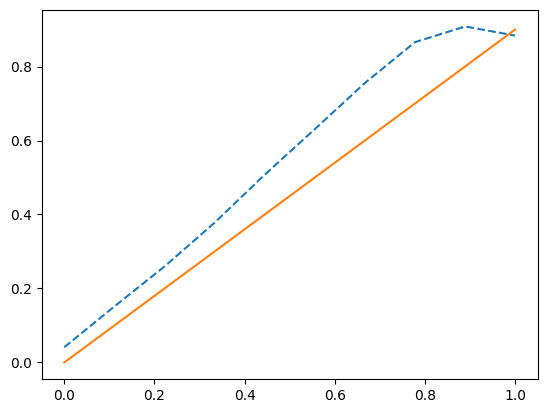

In [14]:
plt.plot(noises,test_errs,linestyle='--',label = 'Laplacian kernel')
plt.plot(noises,0.9*noises,linestyle = '-',label = 'Bayes opt')
plt.show()

In [15]:
test_errs_gaussian = []
for noise in noises:
    for (data, target) in train_loader:
        data, target = data.to(device).reshape(-1, d).double() / math.sqrt(d), target.to(device)
        target = corrupting_label(target, noise)
        one_hot = nn.functional.one_hot(target, 10).double()
        kernel_train = gaussian(data, data, 1.0)
        a = torch.inverse(kernel_train) @ one_hot
        output = kernel_train @ a
        train_loss = torch.norm(output - one_hot) ** 2 / train_size
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum()
        accuracy = correct / train_size
        print(f'training loss is :{train_loss}, training accuracy :{accuracy}')
    for (data_test, target_test) in test_loader:
        data_test, target_test = data_test.to(device).reshape(-1, d).double() / math.sqrt(d), target_test.to(device)
        target_test = corrupting_label(target_test, noise)
        one_hot_test = nn.functional.one_hot(target_test, 10).double()
        kernel_test = gaussian(data_test, data, 1.0)
        output_test = kernel_test @ a
        test_loss = torch.norm(output_test - one_hot_test) ** 2 / test_size
        pred = output_test.argmax(dim=1, keepdim=True)
        correct = pred.eq(target_test.view_as(pred)).sum()
        accuracy = correct / test_size
        print(f'test loss is :{test_loss}, test accuracy :{accuracy}')
        test_errs_gaussian.append(1 - accuracy)


training loss is :1.2633247517671791e-23, training accuracy :1.0
test loss is :0.13440756218339164, test accuracy :0.9643999934196472
training loss is :2.785101001794643e-23, training accuracy :1.0
test loss is :0.46887418291554056, test accuracy :0.8212000131607056
training loss is :8.773836437760942e-23, training accuracy :1.0
test loss is :0.7819377749216369, test accuracy :0.6517999768257141
training loss is :6.200488245808724e-23, training accuracy :1.0
test loss is :1.0518054009887714, test accuracy :0.47999998927116394
training loss is :1.5886415785121792e-22, training accuracy :1.0
test loss is :1.2602494539514955, test accuracy :0.33559998869895935
training loss is :8.291069654247262e-23, training accuracy :1.0
test loss is :1.4083937514889913, test accuracy :0.23680000007152557
training loss is :1.3171327044940885e-22, training accuracy :1.0
test loss is :1.517976206086636, test accuracy :0.1664000004529953
training loss is :2.749287854861328e-22, training accuracy :1.0
test 

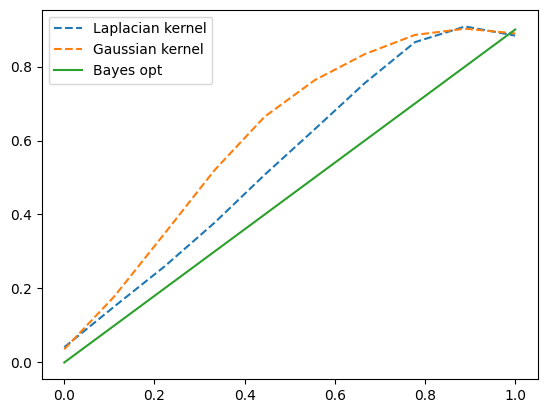

In [17]:
plt.plot(noises,test_errs,linestyle='--',label = 'Laplacian kernel')
plt.plot(noises,test_errs_gaussian,linestyle='--',label = 'Gaussian kernel')
plt.plot(noises,0.9*noises,linestyle = '-',label = 'Bayes opt')
plt.legend()
plt.show()